In [ ]:
# импорты
import pandas as pd
from google.colab import drive
import numpy as np
import os
import re
import requests
import io
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,make_scorer, recall_score
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold,train_test_split, RandomizedSearchCV
from scipy.stats import ttest_rel, wilcoxon, f_oneway

from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive

MyDrive


In [ ]:
# filename = '/content/drive/MyDrive/wr323845.txt'//тест
filename = '/content/drive/MyDrive/wr326452a3.txt'

# Шифры опасных явлений
danger_codes = {'01', '03', '64', '65', '80'}

data = []

with open(filename, 'r', encoding='utf-8') as file:

    for line in file:
        parts = line.strip().split()
        if len(parts) < 8:
            continue

        station_index = parts[0]
        year = int(parts[1])
        month = int(parts[2])
        day = int(parts[3])
        term = int(parts[4])
        event_code = parts[5]
        time_start = parts[6]
        time_end = parts[7]

        thunderstorm = int(event_code in danger_codes)

        data.append({
            'station_index': station_index,
            'year': year,
            'month': month,
            'day': day,
            'term': term,
            'event_code': event_code,
            'time_start': time_start,
            'time_end': time_end,
            'thunderstorm': thunderstorm
        })

df_meteo = pd.DataFrame(data)

df_meteo['event_code'].unique()

array(['11', '63', '64', '10', '62', '21', '80', '23', '22', '65', '73',
       '53', '52'], dtype=object)

In [ ]:
def convert_to_datetime(row):

    hour = int(float(row["time_start"]))
    minute = int(round((float(row["time_start"]) - hour) * 60))
    dt = datetime(row["year"], row["month"], row["day"], hour, minute)

    # преобразование в 00Z или 12Z в зависимости от времени
    if 0 <= dt.hour < 6:
        return dt.replace(hour=0, minute=0)
    elif 6 <= dt.hour < 18:
        return dt.replace(hour=12, minute=0)
    else:
        return dt.replace(hour=0, minute=0)

In [ ]:
df = df_meteo.copy()
df_thunder = df[df["thunderstorm"] == 1].copy()

# преобразование времени
df_thunder["datetime"] = df_thunder.apply(lambda row: convert_to_datetime(row), axis=1)

df_thunder = df_thunder.sort_values("datetime").reset_index(drop=True)

# группировка промежутков по времени
df_thunder["time_diff"] = df_thunder["datetime"].diff().fillna(pd.Timedelta(seconds=0))
df_thunder["new_group"] = (df_thunder["time_diff"] > timedelta(hours=3)).astype(int)
df_thunder["group_id"] = df_thunder["new_group"].cumsum()

grouped_df_list = []

for group_num, group in df_thunder.groupby("group_id"):
    year = group["year"].iloc[0]
    month = group["month"].iloc[0]
    day = group["day"].iloc[0]
    term = group["term"].iloc[0]

     # время начало явления - первая запись в группе
    time_start = group["time_start"].iloc[0]

    formatted_datetime = group["datetime"].max().strftime('%Y-%m-%d %H:%M:%S')

    new_row = pd.DataFrame({
        "year": [year],
        "month": [month],
        "day": [day],
        "term": [term],
        "time_start": [time_start],
        "formatted_datetime": [formatted_datetime]
    })

    grouped_df_list.append(new_row)

grouped_df = pd.concat(grouped_df_list, ignore_index=True)

grouped_df


,year,month,day,term,time_start,formatted_datetime
0,2012,5,5,3,1.20,2012-05-05 00:00:00
1,2012,5,5,9,8.21,2012-05-05 12:00:00
2,2012,5,11,9,8.10,2012-05-11 12:00:00
3,2012,5,12,9,6.03,2012-05-12 12:00:00
4,2012,5,18,9,6.40,2012-05-18 12:00:00
...,...,...,...,...,...,...
462,2017,9,14,15,13.30,2017-09-14 12:00:00
463,2017,9,15,0,21.02,2017-09-15 00:00:00
464,2017,9,15,18,15.50,2017-09-15 12:00:00
465,2017,9,16,15,14.00,2017-09-16 12:00:00


In [ ]:
# функция для формирования строки для записи в файл
def format_row(df, station):

    num_levels = len(df)

    # первая строка с номером станции и общими данными
    first_row = f"1\n{station} {num_levels} "

    # сбор всех данные для уровней, начиная с второй строки
    rows = []
    for index, row in df.iterrows():
        height = row['HGHT']
        pressure = row['PRES']
        temp = row['TEMP'] if row['TEMP'] != 9999.0 else 9999.0
        deficit = row['DEFIICIT'] if row['DEFIICIT'] != 9999.0 else 9999.0
        wind_direction = row['DRCT'] if row['DRCT'] != 9999.0 else 9999.0
        wind_speed = row['SPEED_m_s'] if row['SPEED_m_s'] != 9999.0 else 9999.0

        data_row = f"{height} {pressure} {temp} {deficit} {wind_direction} {wind_speed}"
        rows.append(data_row)

    all_rows = first_row + " ".join(rows) + "\n"

    return all_rows

In [ ]:
# формирование URL
def build_url(station, year, month, day, term):

    base_url = "http://weather.uwyo.edu/cgi-bin/sounding"

    hour = "00" if term < 6 else "12"

    # Параметры запроса
    params = {
        "region": "europe",
        "TYPE": "TEXT%3ALIST",
        "YEAR": year,
        "MONTH": f"{int(month):02}",
        "FROM": f"{int(day):02}{hour}",
        "TO": f"{int(day):02}{hour}",
        "STNM": str(station)
    }

    # строка запроса
    query_string = "&".join([f"{key}={value}" for key, value in params.items()])
    print(f"{base_url}?{query_string}")

    return f"{base_url}?{query_string}"


In [ ]:
# получение данных с сайта Вайоминга
def fetch_sounding_data(station, year, month, day, term, retries=3, delay=8):

    url = build_url(station, year, month, day, term)

    for attempt in range(retries):
        response = requests.get(url, timeout=20)  # добавила тайм аут на 20с если сайт не отвечает
        soup = BeautifulSoup(response.content, 'html.parser')
        pre_tag = soup.find('pre')

        if pre_tag is None:
            if attempt < retries - 1:  # если это не последняя попытка
                print(f"Попытка #{attempt + 1} не удалась. Повтор через {delay} секунд...")
                time.sleep(delay)
            else:
              time.sleep(delay)
              print("Максимальное количество попыток исчерпано.")
            return None

        lines = pre_tag.text.strip().split('\n')

        data_lines = [line for line in lines if not line.startswith('-') and line.strip() != '']

        if len(data_lines) < 2:
            print(f"Нет данных в ответе: {station} {year}-{month}-{day} {term}Z")
            if attempt < retries - 1:
                print(f"Попытка #{attempt + 1} не удалась. Повтор через {delay} секунд...")
                time.sleep(delay)
            else:
                time.sleep(delay)
                print("Максимальное количество попыток исчерпано.")
            return None

        data_str = '\n'.join(data_lines[2:])
        data_io = io.StringIO(data_str)

        columns = ["PRES", "HGHT", "TEMP", "DWPT", "RELH", "MIXR", "DRCT", "SKNT", "THTA", "THTE", "THTV"]
        df = pd.read_fwf(data_io, header=None, names=columns)

        # замена NaN на 9999.0
        df.fillna(9999.0, inplace=True)
        df = df[["PRES", "HGHT","TEMP", "DWPT", "DRCT", "SKNT"]]

        df['DEFIICIT'] = df['TEMP'] - df['DWPT']
        df.loc[(df['TEMP'] == 9999.0) | (df['DWPT'] == 9999.0), 'DEFIICIT'] = 9999
        df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)

        # перевод скорость из узлов в м/с
        df['SPEED_m_s'] = df['SKNT'] * 0.514444
        df.loc[(df['SKNT'] == 9999.0), 'SPEED_m_s'] = 9999
        df['SPEED_m_s'] = df['SPEED_m_s'].round(1)

        return df

In [ ]:
# Загружаем датафрейм с группами
grouped_df2 = grouped_df
sounding_dfs = []
written_files = set()

# Обработка каждой строки
for idx, row in grouped_df2.iterrows():
    year = row['year']
    month = row['month']
    day = row['day']
    term = row['term']

    station = 26063

    # получение данных радиозондирования
    df = fetch_sounding_data(station, year, month, day, term)

    save_dir = '/content/drive/MyDrive/soundingsVKR_dang'
    if df is not None:
        sounding_dfs.append(df)
        row = format_row(df, 26063)
        print(f"Загружен датафрейм для {year}-{month}-{day} {term}Z")

        last_two_digits_of_year = str(year)[-2:]
        hour = "00" if term < 6 else "12"

        # имя файла
        file_name = f"{station}_{year}{month:02}{day:02}_{hour}.{last_two_digits_of_year}K"
        written_files.add(file_name)
        file_path = os.path.join(save_dir, file_name)
        print(file_name)
        with open(file_path, 'w') as file:
            file.write(row)
            # a=1

        print(f"Файл сохранен: {file_path}")

    else:
        print(f"Нет данных для {year}-{month}-{day} {term}Z")

# После обработки всех групп выводим количество строк в каждом датафрейме
print("\nОбщее количество строк в каждом из датафреймов:")
for i, df in enumerate(sounding_dfs, 1):
    print(f"Гроза #{i}: {len(df)} строк")

# Количество элементов в списке
print("\nОбщее количество обработанных датафреймов: " + str(len(sounding_dfs)))
print(f"\nКоличество уникальных записанных файлов: {len(written_files)}")



http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2012&MONTH=05&FROM=0500&TO=0500&STNM=26063
Загружен датафрейм для 2012-5-5 3Z
26063_20120505_00.12K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20120505_00.12K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2012&MONTH=05&FROM=0512&TO=0512&STNM=26063
Загружен датафрейм для 2012-5-5 9Z
26063_20120505_12.12K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20120505_12.12K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2012&MONTH=05&FROM=1112&TO=1112&STNM=26063
Загружен датафрейм для 2012-5-11 9Z
26063_20120511_12.12K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20120511_12.12K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2012&MONTH=05&FROM=1212&TO=1212&STNM=26063
Загружен датафрейм для 2012-5-12 9Z
26063_20120512_12.12K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/

<ipython-input-12-0ae8831c0df7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['TEMP'] - df['DWPT']
<ipython-input-12-0ae8831c0df7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)
<ipython-input-12-0ae8831c0df7>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Загружен датафрейм для 2013-7-16 12Z
26063_20130716_12.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130716_12.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=07&FROM=1812&TO=1812&STNM=26063
Загружен датафрейм для 2013-7-18 21Z
26063_20130718_12.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130718_12.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=07&FROM=1812&TO=1812&STNM=26063
Загружен датафрейм для 2013-7-18 18Z
26063_20130718_12.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130718_12.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=07&FROM=1900&TO=1900&STNM=26063
Загружен датафрейм для 2013-7-19 0Z
26063_20130719_00.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130719_00.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=07&FR

<ipython-input-12-0ae8831c0df7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['TEMP'] - df['DWPT']
<ipython-input-12-0ae8831c0df7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)
<ipython-input-12-0ae8831c0df7>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Загружен датафрейм для 2013-8-14 9Z
26063_20130814_12.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130814_12.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=08&FROM=1512&TO=1512&STNM=26063
Загружен датафрейм для 2013-8-15 21Z
26063_20130815_12.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130815_12.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=08&FROM=1512&TO=1512&STNM=26063
Загружен датафрейм для 2013-8-15 18Z
26063_20130815_12.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130815_12.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=08&FROM=1600&TO=1600&STNM=26063
Загружен датафрейм для 2013-8-16 3Z
26063_20130816_00.13K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20130816_00.13K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2013&MONTH=08&FRO

<ipython-input-12-0ae8831c0df7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['TEMP'] - df['DWPT']
<ipython-input-12-0ae8831c0df7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)
<ipython-input-12-0ae8831c0df7>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Загружен датафрейм для 2015-7-31 15Z
26063_20150731_12.15K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20150731_12.15K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=08&FROM=0212&TO=0212&STNM=26063
Загружен датафрейм для 2015-8-2 18Z
26063_20150802_12.15K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20150802_12.15K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=08&FROM=0312&TO=0312&STNM=26063
Загружен датафрейм для 2015-8-3 6Z
26063_20150803_12.15K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20150803_12.15K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=08&FROM=0312&TO=0312&STNM=26063
Загружен датафрейм для 2015-8-3 9Z
26063_20150803_12.15K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20150803_12.15K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2015&MONTH=08&FROM=0

<ipython-input-12-0ae8831c0df7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['TEMP'] - df['DWPT']
<ipython-input-12-0ae8831c0df7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)
<ipython-input-12-0ae8831c0df7>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Загружен датафрейм для 2017-7-21 15Z
26063_20170721_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170721_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=07&FROM=2212&TO=2212&STNM=26063
Загружен датафрейм для 2017-7-22 18Z
26063_20170722_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170722_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=07&FROM=2412&TO=2412&STNM=26063
Загружен датафрейм для 2017-7-24 6Z
26063_20170724_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170724_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=07&FROM=2412&TO=2412&STNM=26063
Загружен датафрейм для 2017-7-24 15Z
26063_20170724_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170724_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=07&FR

<ipython-input-12-0ae8831c0df7>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['TEMP'] - df['DWPT']
<ipython-input-12-0ae8831c0df7>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)
<ipython-input-12-0ae8831c0df7>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Загружен датафрейм для 2017-8-22 9Z
26063_20170822_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170822_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=08&FROM=2300&TO=2300&STNM=26063
Загружен датафрейм для 2017-8-23 3Z
26063_20170823_00.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170823_00.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=08&FROM=2312&TO=2312&STNM=26063
Загружен датафрейм для 2017-8-23 18Z
26063_20170823_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170823_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=08&FROM=2412&TO=2412&STNM=26063
Загружен датафрейм для 2017-8-24 21Z
26063_20170824_12.17K
Файл сохранен: /content/drive/MyDrive/soundingsVKR_dang/26063_20170824_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=08&FRO

In [ ]:
def to_datetime(df):
    return pd.to_datetime(df[['year', 'month', 'day']])

# term в 00 или 12
def convert_term_to_hour(term):
    return "00" if term < 6 else "12"

In [ ]:
# формируем дф неопасных СПОСОБ промежуток между днями
import pandas as pd
from datetime import datetime

df_all = df_meteo.copy()
df_dangerous = grouped_df.copy()

df_all['datetime'] = to_datetime(df_all)
df_dangerous['datetime'] = to_datetime(df_dangerous)

df_all['hour'] = df_all['term'].apply(convert_term_to_hour)
df_all_unique = df_all[['datetime', 'hour', 'thunderstorm']].drop_duplicates()

df_dangerous['hour'] = df_dangerous['term'].apply(convert_term_to_hour)
df_dangerous = df_dangerous[['datetime', 'hour']]
df_dangerous = df_dangerous.drop_duplicates(subset=['datetime', 'hour'])

df_calm = df_all_unique[df_all_unique['thunderstorm'] == 0].copy()
danger_dates = df_all[df_all['thunderstorm'] == 1]['datetime'].unique()
df_calm = df_calm[~df_calm['datetime'].isin(danger_dates)].copy()

used_indexes = set()
used_calm_dates = set()
pairs = []

# макс кол-во дней для поиска ближ даты
max_days_diff = 14

for _, row in df_dangerous.iterrows():
    danger_date = row['datetime']
    print(danger_date)

    df_calm['delta'] = df_calm['datetime'].apply(lambda d: abs((d - danger_date).days))

    # свободные даты
    unused = df_calm[
        (~df_calm.index.isin(used_indexes)) &
        (~df_calm['datetime'].isin(used_calm_dates)) &
        (df_calm['datetime'] != danger_date) &
        (df_calm['delta'] <= max_days_diff)
    ]

    print(unused)

    if not unused.empty:
        nearest_idx = unused['delta'].idxmin()
        calm_day = unused.loc[nearest_idx]

        used_indexes.add(nearest_idx)
        used_calm_dates.add(calm_day['datetime'])
        calm_term = calm_day['hour']
        print(calm_day['datetime'])

        pairs.append({
            'danger_date': danger_date,
            'calm_date': calm_day['datetime'],
            'calm_term': calm_term
        })

matched_df = pd.DataFrame(pairs)

print(matched_df)


import requests


sounding_dfs = []
station = 26063
for i, row in matched_df.iterrows():
    year = row['calm_date'].year
    month = row['calm_date'].month
    day = row['calm_date'].day
    term = int(row['calm_term'])

    year2 = row['danger_date'].year
    month2 = row['danger_date'].month
    day2 = row['danger_date'].day

    df = fetch_sounding_data(station, year, month, day, term)

    save_dir = '/content/drive/MyDrive/soundingsVKR_good2/'
    if df is not None:

        sounding_dfs.append(df)
        row = format_row(df, 26063)
        print(f"Загружен датафрейм для {year}-{month}-{day} {term}Z для {year2}-{month2}-{day2}")

        last_two_digits_of_year = str(year)[-2:]
        hour = "00" if term < 6 else "12"

        file_name = f"{station}_{year}{month:02}{day:02}_{hour}.{last_two_digits_of_year}K"
        file_path = os.path.join(save_dir, file_name)
        print(file_name)
        with open(file_path, 'w') as file:
            file.write(row)
        print(f"Файл сохранен: {file_path}")

    else:
        print(f"Нет данных для {year}-{month}-{day} {term}Z")

print("\n Кол-во строк в каждом из датафреймов:")
for i, df in enumerate(sounding_dfs, 1):
    print(f"Гроза #{i}: {len(df)} строк")

print("\n Кол-во обработанных датафреймов: " + str(len(sounding_dfs)))


Выходные данные были обрезаны до нескольких последних строк (5000).
2154 2013-09-09   12             0      8
2157 2013-09-10   00             0      9
2159 2013-09-10   12             0      9
2161 2013-09-11   00             0     10
2163 2013-09-11   12             0     10
2174 2013-09-13   00             0     12
2176 2013-09-13   12             0     12
2180 2013-09-14   00             0     13
2183 2013-09-14   12             0     13
2186 2013-09-15   00             0     14
2188 2013-09-15   12             0     14
2013-08-31 00:00:00
2013-09-02 00:00:00
       datetime hour  thunderstorm  delta
2042 2013-08-25   00             0      8
2046 2013-08-25   12             0      8
2050 2013-08-26   00             0      7
2052 2013-08-26   12             0      7
2053 2013-08-27   00             0      6
2055 2013-08-27   12             0      6
2056 2013-08-28   00             0      5
2057 2013-08-28   12             0      5
2117 2013-09-03   00             0      1
2119 2013-

In [ ]:
# способ -  в рамках одного дня допускаем как опасное так и спокойное явл
import pandas as pd
from datetime import datetime


# === Подгрузка датафреймов ===
df_all = df_meteo.copy()
df_dangerous = grouped_df2.copy()

df_all['datetime'] = to_datetime(df_all)
df_dangerous['datetime'] = to_datetime(df_dangerous)

df_all['hour'] = df_all['term'].apply(convert_term_to_hour)
df_dangerous['hour'] = df_dangerous['term'].apply(convert_term_to_hour)

# Убираем дубликаты
df_all_unique = df_all[['datetime', 'hour', 'thunderstorm']].drop_duplicates()
df_dangerous = df_dangerous[['datetime', 'hour']].drop_duplicates()

# Отбираем только спокойные (без грозы), исключая даты с грозой вообще
df_calm = df_all_unique[df_all_unique['thunderstorm'] == 0].copy()
danger_dates = df_all[df_all['thunderstorm'] == 1]['datetime'].unique()
df_calm = df_calm[~df_calm['datetime'].isin(danger_dates)].copy()


used_calm_slots = set()
pairs = []

max_days_diff = 14

for _, row in df_dangerous.iterrows():
    danger_date = row['datetime']
    danger_hour = row['hour']

    df_calm['delta'] = df_calm['datetime'].apply(lambda d: abs((d - danger_date).days))

    # доступные спокойные строки
    unused = df_calm[
        (~df_calm.apply(lambda x: (x['datetime'], x['hour']) in used_calm_slots, axis=1)) &
        (df_calm['datetime'] != danger_date) &
        (df_calm['delta'] <= max_days_diff)
    ]

    if not unused.empty:
        nearest_idx = unused['delta'].idxmin()
        calm_row = unused.loc[nearest_idx]
        used_calm_slots.add((calm_row['datetime'], calm_row['hour']))

        pairs.append({
            'danger_date': danger_date,
            'danger_hour': danger_hour,
            'calm_date': calm_row['datetime'],
            'calm_hour': calm_row['hour']
        })
        # print(danger_date)
        # print(calm_row['datetime'])

# итог табл
matched_df = pd.DataFrame(pairs)
print(matched_df)


sounding_dfs = []
written_files = set()
station = 26063
for i, row in matched_df.iterrows():
    year = row['calm_date'].year
    month = row['calm_date'].month
    day = row['calm_date'].day
    term = int(row['calm_hour'])

    year2 = row['danger_date'].year
    month2 = row['danger_date'].month
    day2 = row['danger_date'].day

    df = fetch_sounding_data(station, year, month, day, term)

    save_dir = '/content/drive/MyDrive/soundingsVKR_good/'
    if df is not None:
        sounding_dfs.append(df)
        row = format_row(df, 26063)
        print(f"Загружен датафрейм для {year}-{month}-{day} {term}Z для {year2}-{month2}-{day2}")

        # имя файла
        last_two_digits_of_year = str(year)[-2:]
        hour = "00" if term < 6 else "12"
        file_name = f"{station}_{year}{month:02}{day:02}_{hour}.{last_two_digits_of_year}K"
        file_path = os.path.join(save_dir, file_name)
        written_files.add(file_name)
        # print(file_name)

        with open(file_path, 'w') as file:
            file.write(row)

        # print(f"Файл сохранен: {file_path}")

    else:
        print(f"Нет данных для {year}-{month}-{day} {term}Z")


print("\n Кол-во строк в каждом из датафреймов:")
for i, df in enumerate(sounding_dfs, 1):
    print(f"Гроза #{i}: {len(df)} строк")

print("\n Кол-во обработанных датафреймов: " + str(len(sounding_dfs)))

len(written_files)



    danger_date danger_hour  calm_date calm_hour
0    2012-05-05          00 2012-05-04        00
1    2012-05-05          12 2012-05-04        12
2    2012-05-11          12 2012-05-08        00
3    2012-05-12          12 2012-05-07        00
4    2012-05-18          12 2012-05-19        00
..          ...         ...        ...       ...
368  2017-09-14          12 2017-09-11        12
369  2017-09-15          00 2017-09-17        00
370  2017-09-15          12 2017-09-17        12
371  2017-09-16          12 2017-09-19        00
372  2017-09-18          12 2017-09-19        12

[373 rows x 4 columns]
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2012&MONTH=05&FROM=0400&TO=0400&STNM=26063
Загружен датафрейм для 2012-5-4 0Z для 2012-5-5
26063_20120504_00.12K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2012&MONTH=05&FROM=0412&TO=0412&STNM=26063
Загружен датафрейм для 2012-5-4 12Z для 2012-5-5
26063_20120504_12.12K
http://

<ipython-input-48-648bdbc2b1bd>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['TEMP'] - df['DWPT']
<ipython-input-48-648bdbc2b1bd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEFIICIT'] = df['DEFIICIT'].abs().round(1)
<ipython-input-48-648bdbc2b1bd>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

Загружен датафрейм для 2017-9-17 12Z для 2017-9-15
26063_20170917_12.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=09&FROM=1900&TO=1900&STNM=26063
Загружен датафрейм для 2017-9-19 0Z для 2017-9-16
26063_20170919_00.17K
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2017&MONTH=09&FROM=1912&TO=1912&STNM=26063
Загружен датафрейм для 2017-9-19 12Z для 2017-9-18
26063_20170919_12.17K

Общее количество строк в каждом из датафреймов:
Гроза #1: 75 строк
Гроза #2: 64 строк
Гроза #3: 72 строк
Гроза #4: 70 строк
Гроза #5: 58 строк
Гроза #6: 55 строк
Гроза #7: 68 строк
Гроза #8: 81 строк
Гроза #9: 70 строк
Гроза #10: 62 строк
Гроза #11: 69 строк
Гроза #12: 71 строк
Гроза #13: 48 строк
Гроза #14: 66 строк
Гроза #15: 65 строк
Гроза #16: 68 строк
Гроза #17: 74 строк
Гроза #18: 73 строк
Гроза #19: 70 строк
Гроза #20: 75 строк
Гроза #21: 66 строк
Гроза #22: 61 строк
Гроза #23: 73 строк
Гроза #24: 76 строк
Гроза #25: 55 строк
Гр

369

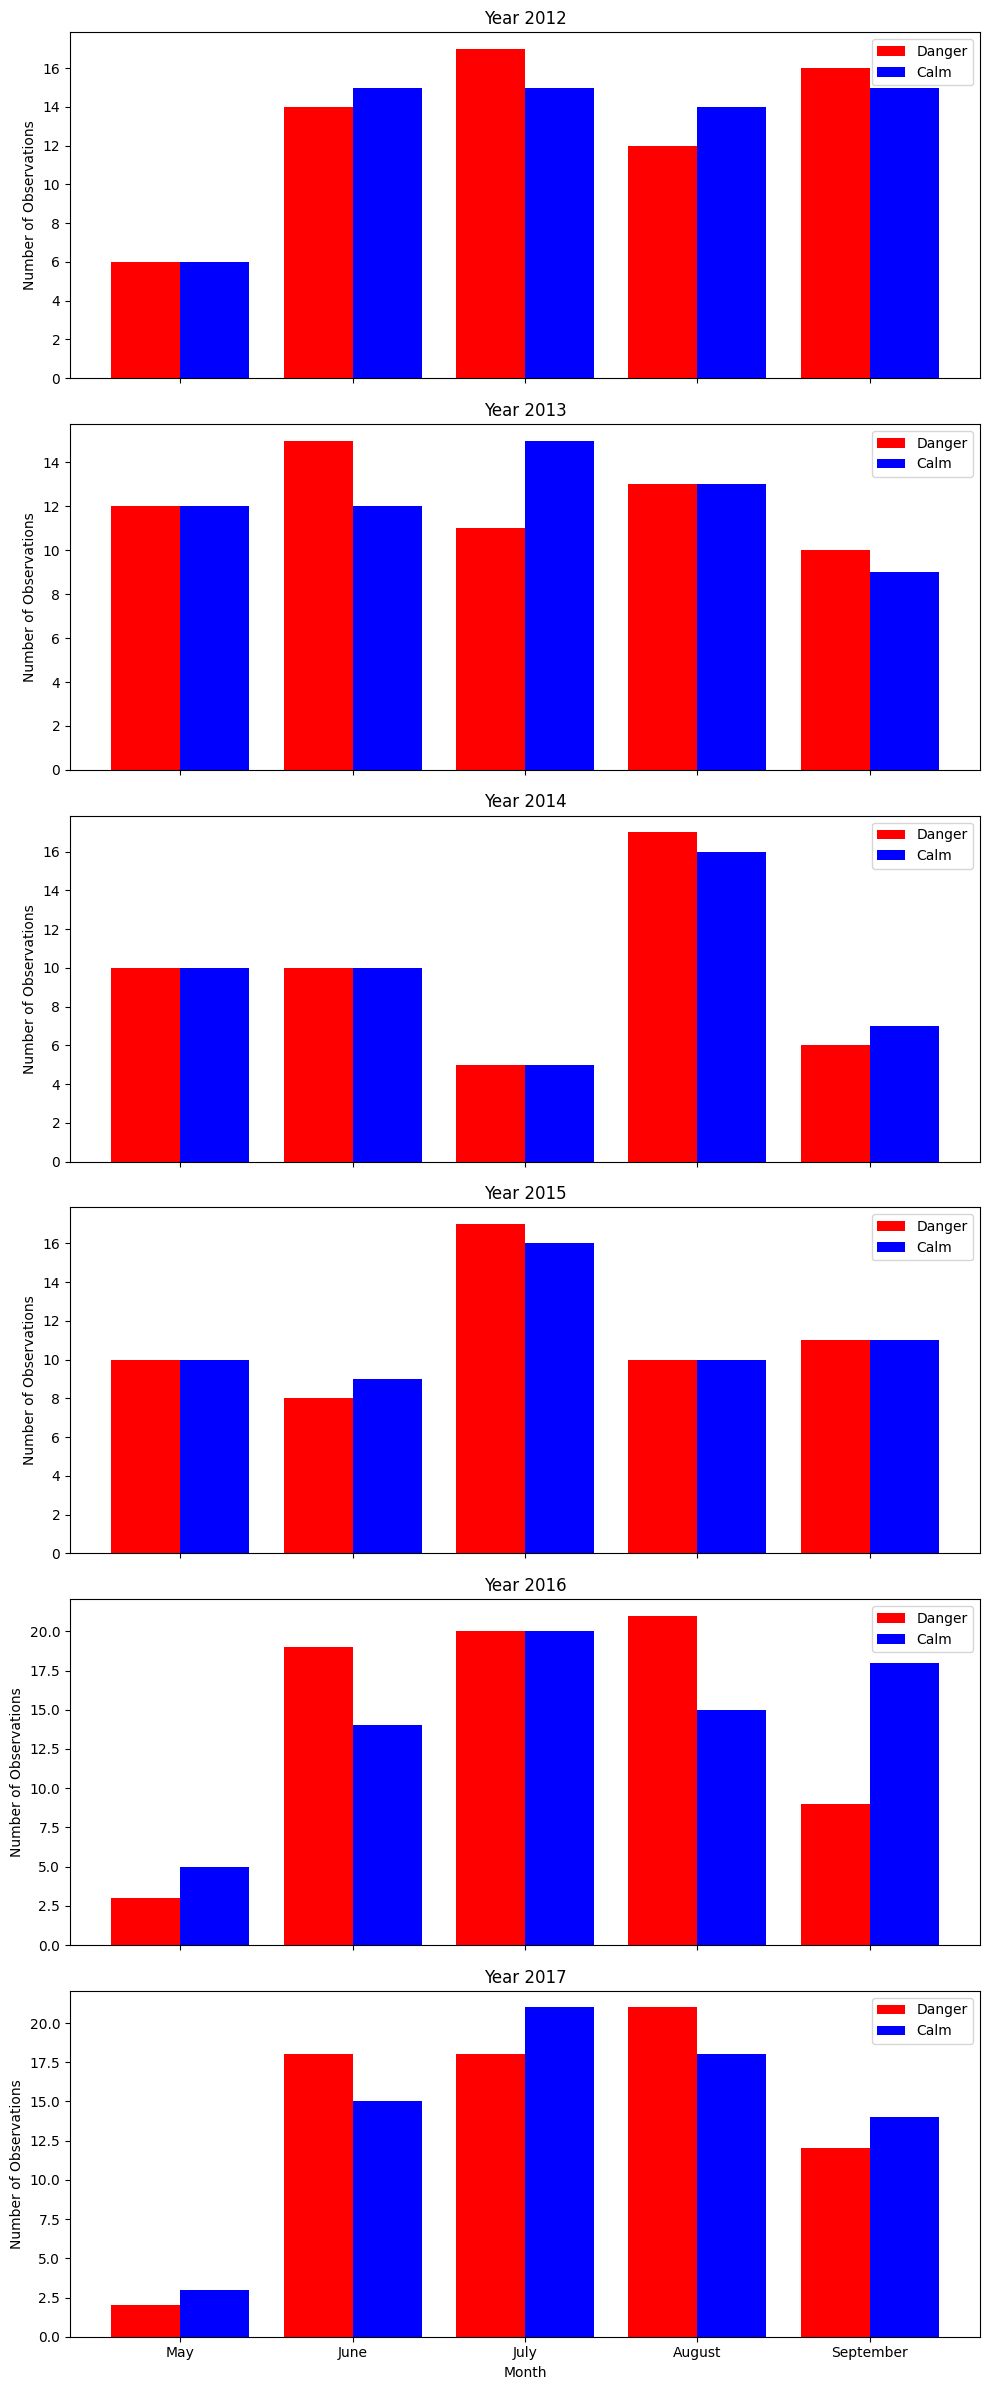

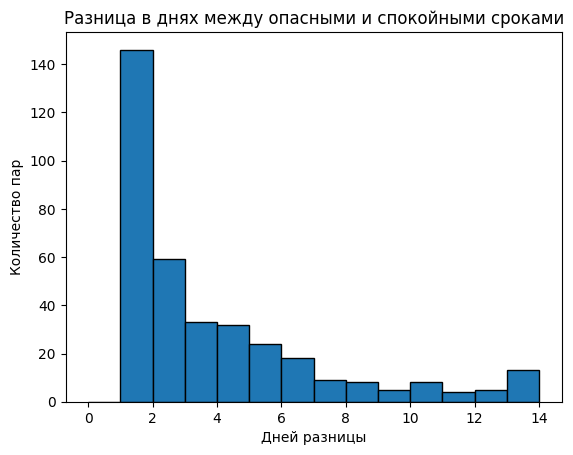

Пары с разницей более 8 дней:
    danger_date danger_hour  calm_date calm_hour  danger_year  danger_month  \
125  2013-09-28          12 2013-09-18        00         2013             9   
240  2016-06-11          12 2016-05-30        12         2016             6   
241  2016-06-12          00 2016-06-24        12         2016             6   
242  2016-06-16          12 2016-06-25        00         2016             6   
244  2016-06-18          00 2016-06-27        00         2016             6   
245  2016-06-18          12 2016-06-29        00         2016             6   
246  2016-06-19          12 2016-06-29        12         2016             6   
247  2016-06-20          12 2016-06-30        00         2016             6   
248  2016-06-21          12 2016-06-30        12         2016             6   
251  2016-06-28          12 2016-07-11        00         2016             6   
253  2016-07-04          00 2016-07-14        12         2016             7   
254  2016-07-04       

In [ ]:
# анализ подобранных дней и дат

import pandas as pd
import matplotlib.pyplot as plt

matched_df['danger_date'] = pd.to_datetime(matched_df['danger_date'])
matched_df['calm_date'] = pd.to_datetime(matched_df['calm_date'])

matched_df['danger_year'] = matched_df['danger_date'].dt.year
matched_df['danger_month'] = matched_df['danger_date'].dt.month
matched_df['calm_year'] = matched_df['calm_date'].dt.year
matched_df['calm_month'] = matched_df['calm_date'].dt.month


matched_df = matched_df[
    matched_df['danger_month'].between(5, 9) |
    matched_df['calm_month'].between(5, 9)
]

years = sorted(set(matched_df['danger_year']) | set(matched_df['calm_year']))
month_names = ['May', 'June', 'July', 'August', 'September']
month_numbers = [5, 6, 7, 8, 9]


n_years = len(years)
fig, axes = plt.subplots(n_years, 1, figsize=(10, 4 * n_years), sharex=True)

if n_years == 1:
    axes = [axes]

for ax, year in zip(axes, years):

    danger_counts = (
        matched_df[matched_df['danger_year'] == year]['danger_month']
        .value_counts().reindex(month_numbers, fill_value=0)
    )
    calm_counts = (
        matched_df[matched_df['calm_year'] == year]['calm_month']
        .value_counts().reindex(month_numbers, fill_value=0)
    )

    # Отрисовка
    ax.bar([x - 0.2 for x in month_numbers], danger_counts, width=0.4, label='Danger', color='red')
    ax.bar([x + 0.2 for x in month_numbers], calm_counts, width=0.4, label='Calm', color='blue')
    ax.set_title(f"Year {year}")
    ax.set_ylabel("Number of Observations")
    ax.legend()
    ax.set_xticks(month_numbers)
    ax.set_xticklabels(month_names)

plt.xlabel("Month")
plt.tight_layout()
plt.show()


# ----------
matched_df['day_diff'] = (matched_df['danger_date'] - matched_df['calm_date']).dt.days.abs()

plt.hist(matched_df['day_diff'], bins=range(0, 15), edgecolor='black')
plt.title('Разница в днях между опасными и спокойными сроками')
plt.xlabel('Дней разницы')
plt.ylabel('Количество пар')
plt.show()


matched_df['day_diff'] = (matched_df['danger_date'] - matched_df['calm_date']).dt.days.abs()


too_distant_pairs = matched_df[matched_df['day_diff'] > 8]

print("Пары с разницей более 8 дней:")
print(too_distant_pairs)

In [ ]:
# код скрипта1 преобразование данных

import os
import re

def main():
    input_directory = 'Data/'
    output_directory = 'NewData/'

    os.makedirs(output_directory, exist_ok=True)
    input_files = [f for f in os.listdir(input_directory) if not f.endswith('~')]

    for input_file in input_files:
        input_path = os.path.join(input_directory, input_file)
        output_path = os.path.join(output_directory, input_file)

        with open(input_path, 'r', encoding='utf-8') as infile, \
             open(output_path, 'w', encoding='utf-8') as outfile:

            for line in infile:
                cleaned_line = re.sub(r'\s+', ' ', line.strip())
                outfile.write(cleaned_line + '\n')

        print(f"Файл обработан: {input_file}")

if __name__ == "__main__":
    main()

# код скрипта2 борьба с зондировками

import os
import re

def interpol(h1, h2, value1, value2):
    h1 = float(h1)
    h2 = float(h2)
    value1 = float(value1)
    value2 = float(value2)
    if value1 == 9999.0 or value2 == 9999.0:
        return '9999.0'
    r = (value2 - value1) / (h2 - h1)
    return str(value1 - r * h1)

def interpol2(h1, h2, value1, value2, h):
    h1 = float(h1)
    h2 = float(h2)
    value1 = float(value1)
    value2 = float(value2)
    if value1 == 9999.0 or value2 == 9999.0:
        return '9999.0'
    r = (value2 - value1) / (h2 - h1)
    return str(value2 - r * (h2 - h))

def main():
    input_directory = 'Data/'
    output_data = 'NewData/'
    input_files = [f for f in os.listdir(input_directory) if not f.endswith('~')]
    cnt = 0

    for input_file in input_files:
        try:
            with open(os.path.join(input_directory, input_file), 'r', encoding='utf-8', errors='ignore') as file:
                data = file.read()
            data = re.sub(r'\s+', ' ', data).split()
            data = [0] + data

            num_h = 6
            while float(data[num_h]) == 9999.0 or float(data[num_h]) == 0:
                num_h += 6
            h = float(data[num_h]) * 122.
            if h < 0:
                h = 0

            newData = []
            if h != 0:
                num = 4
                while float(data[num]) < h and abs(float(data[num]) - h) > 50:
                    num += 6
                print(f"{num}: {h}, {data[num]}")

            if abs(float(data[num]) - h) < 50:
                newData.extend([0])
                newData.append(interpol(data[4], data[16], data[5], data[17]))  # mb
                next_i = 2
                while float(data[num + next_i]) == 9999.0:
                    next_i += 6
                newData.append(str((float(data[num + next_i - 2]) / 100.) + 2. + float(data[num + next_i])))
                newData.append(data[7])
                newData.append(data[8])
                newData.append(interpol(data[4], data[10], data[9], data[21]))
            else:
                mb = interpol2(data[num - 6], data[num], data[num - 5], data[num + 1], h)
                t = interpol2(data[num - 6], data[num], data[num - 4], data[num + 2], h)
                diff_t = data[num + 3]
                vector = data[num + 4]
                velocity = interpol2(data[num - 6], data[num], data[num - 5], data[num + 5], h)

                newData.extend([0])
                newData.append(interpol(data[4], str(h), data[5], mb))
                newData.append(str((float(h) / 100.) + 2. + float(t)))
                newData.append(data[7])
                newData.append(data[8])
                newData.append(interpol(data[4], str(h), data[9], velocity))

                newData.extend([h, mb, t, diff_t, vector, velocity])

            j = num
            while j < len(data) - 1 and float(data[j]) != 9999.0 and float(data[j]) < 12001:
                j += 6

            i = num
            while i < j and i < len(data) - 1:
                newData.append(data[i])
                i += 1

            with open(os.path.join(output_data, input_file), 'w', encoding='utf-8') as out:
                out.write(f"1 {data[2]} {len(newData) // 6} ")
                out.write(' '.join(str(val) for val in newData))

        except Exception as e:
            cnt += 1
            print(f"exception: {output_data + input_file} | {e}")
            try:
                os.remove(os.path.join(output_data, input_file))
            except:
                pass

    print(cnt)

if __name__ == "__main__":
    main()

In [ ]:
# этап 6 находим макс по верт мощности и тд
# директории с файлами
GOOD_DIR = "/content/drive/MyDrive/vkr_cloud_good2"   # target = 0
DANG_DIR = "/content/drive/MyDrive/vkr_cloud_dang"   # target = 1
OUTPUT_DIR = os.path.join(GOOD_DIR, "OutPut")
os.makedirs(OUTPUT_DIR, exist_ok=True)

threshold = 0.0015
priority_features = [
    'velocity', 'velocityU', 'temperature', 'deltaTemperature',
    'relativeHumidity', 'vapor', 'pressure', 'density',
    'aerosol', 'drop', 'ice', 'hailAndGrits'
]

summary_rows = []

for folder_path, target_value in [(GOOD_DIR, 0), (DANG_DIR, 1)]:
    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(".csv"):
            continue

        input_path = os.path.join(folder_path, filename)

        try:
            df = pd.read_csv(input_path, encoding='cp1251', on_bad_lines='skip')
            df.columns = df.columns.str.strip()
            df.rename(columns={'Время(с)': 'Time(s)', 'Высота(м)': 'Height(m)'}, inplace=True)

            required_cols = {'Time(s)', 'Height(m)', 'Название параметра', 'Значение параметра'}
            if not required_cols.issubset(df.columns):
                raise ValueError("Файл не содержит всех необходимых колонок")

            pivot = df.pivot_table(index=['Time(s)', 'Height(m)'],
                                   columns='Название параметра',
                                   values='Значение параметра').reset_index()

            pivot['deltaTemperature'] = pivot.groupby('Time(s)')['temperature'].diff().fillna(0)
            pivot['vert_power'] = pivot['velocity']**2 + pivot['velocityU']**2
            pivot['water_availab'] = pivot[['drop', 'ice', 'hailAndGrits']].fillna(0).sum(axis=1)

            max_thickness = 0
            selected_time = None

            for time, group in pivot.groupby('Time(s)'):
                water_by_h = group.set_index('Height(m)')['water_availab']
                significant = water_by_h[water_by_h >= threshold]

                if not significant.empty:
                    thickness = significant.index.max() - significant.index.min()
                    if thickness > max_thickness:
                        max_thickness = thickness
                        selected_time = time

            if selected_time is None:
                print(f"✗ Нет подходящего слоя в {filename}")
                continue

            selected_slice = pivot[pivot['Time(s)'] == selected_time].copy()
            max_water_row = selected_slice.loc[selected_slice['water_availab'].idxmax()].copy()

            output_row = max_water_row.drop(['vert_power', 'water_availab'])
            output_row['vertical_thickness'] = max_thickness
            output_row['vert_power'] = max_water_row['vert_power']
            output_row['target'] = target_value

            all_columns = list(output_row.index)
            rest = [col for col in all_columns if col not in priority_features + ['vertical_thickness', 'vert_power', 'target']]
            ordered_columns = [col for col in priority_features if col in all_columns] + rest + ['vertical_thickness', 'vert_power', 'target']
            output_row = output_row[ordered_columns]

            match = re.search(r"_(\d{8})_", filename)
            output_row['date'] = pd.to_datetime(match.group(1), format='%Y%m%d') if match else pd.NaT

            match_time = re.search(r"_(\d{2})\.", filename)
            output_row['term'] = match_time.group(1) if match_time else None

            summary_rows.append(output_row)

        except Exception as e:
            print(f"✗ Ошибка при обработке файла {filename}: {e}")

summary_df = pd.DataFrame(summary_rows)
cols = ['date', 'term'] + [col for col in summary_df.columns if col not in ['date', 'term']]
summary_df = summary_df[cols]
summary_df.to_csv(os.path.join(OUTPUT_DIR, "summary_features4.csv"), index=False)

print("Сводный файл 'summary_features.csv' успешно создан.")


Mounted at /content/drive
✗ Нет подходящего слоя в 26063_20120504_00.12K.csv
✗ Нет подходящего слоя в 26063_20120506_12.12K.csv
✗ Нет подходящего слоя в 26063_20120508_00.12K.csv
✗ Нет подходящего слоя в 26063_20120519_00.12K.csv
✗ Нет подходящего слоя в 26063_20120601_00.12K.csv
✗ Нет подходящего слоя в 26063_20120605_00.12K.csv
✗ Нет подходящего слоя в 26063_20120623_00.12K.csv
✗ Нет подходящего слоя в 26063_20120630_00.12K.csv
✗ Нет подходящего слоя в 26063_20120703_00.12K.csv
✗ Нет подходящего слоя в 26063_20120705_00.12K.csv
✗ Нет подходящего слоя в 26063_20120706_12.12K.csv
✗ Нет подходящего слоя в 26063_20120802_12.12K.csv
✗ Нет подходящего слоя в 26063_20120811_12.12K.csv
✗ Нет подходящего слоя в 26063_20120812_00.12K.csv
✗ Нет подходящего слоя в 26063_20120813_00.12K.csv
✗ Нет подходящего слоя в 26063_20120821_00.12K.csv
✗ Нет подходящего слоя в 26063_20120822_00.12K.csv
✗ Нет подходящего слоя в 26063_20120831_00.12K.csv
✗ Нет подходящего слоя в 26063_20120901_00.12K.csv
✗ Нет

In [ ]:
df

,date,Time(s),Height(m),aerosol,density,drop,hailAndGrits,ice,pressure,relativeHumidity,temperature,vapor,velocity,velocityU,deltaTemperature,vert_power,target,term
0,2012-05-04,400.0,5800.0,0.000000e+00,0.657201,0.000000,0.000000,0.000075,46932.612,0.798280,248.78200,0.000896,0.321569,-0.707696,-1.41368,0.604240,0.0,0
1,2012-05-06,960.0,0.0,6.095088e-07,1.190299,0.000000,0.000000,0.000000,101058.340,0.407540,295.77297,0.006890,0.000000,0.000000,0.00000,0.000000,0.0,12
2,2012-05-07,940.0,4000.0,0.000000e+00,0.799511,0.006627,0.000008,0.000198,61526.122,0.995054,268.08819,0.004218,19.040368,5.730979,-1.34028,395.379732,0.0,0
3,2012-05-08,960.0,2200.0,0.000000e+00,1.006192,0.000424,0.000605,0.000475,77268.576,0.985314,267.52498,0.003186,8.289248,17.402415,-1.51992,371.555685,0.0,0
4,2012-05-19,960.0,1000.0,7.675545e-13,1.135679,0.000225,0.000000,0.000000,90461.911,1.001721,277.49333,0.005740,3.585067,8.720009,-1.49132,88.891271,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2017-09-14,960.0,3800.0,0.000000e+00,0.808475,0.006949,0.000021,0.000047,62015.006,0.996316,267.22223,0.003922,15.604874,3.942808,-1.38679,259.057831,1.0,12
695,2017-09-15,720.0,2600.0,0.000000e+00,0.919376,0.004680,0.000000,0.000000,72241.627,0.996617,273.73921,0.005471,14.335605,2.630945,-1.26040,212.431442,1.0,0
696,2017-09-15,540.0,9400.0,0.000000e+00,0.436262,0.000000,0.000000,0.002249,29353.492,1.034059,234.39841,0.000460,23.909894,10.647837,-1.91506,685.059464,1.0,12
697,2017-09-16,960.0,3400.0,0.000000e+00,0.860989,0.004910,0.000056,0.000023,66255.457,0.996475,268.08140,0.003920,15.014556,1.213386,-1.35002,226.909198,1.0,12


In [ ]:
# ---------------------ОБУЧЕНИЕ--------------------------------

In [ ]:
pip install imbalanced-learn

In [ ]:
df = pd.read_csv(os.path.join("/content/drive/MyDrive/vkr_cloud_good2/OutPut/summary_features4.csv"))
df.sort_values(by='date')

,date,term,velocity,velocityU,temperature,deltaTemperature,relativeHumidity,vapor,pressure,density,aerosol,drop,ice,hailAndGrits,Time(s),Height(m),vertical_thickness,vert_power,target
247,2012-05-05,12,8.786745,11.782798,269.12077,-1.24756,0.996747,0.004278,65706.390,0.850556,0.000000e+00,0.005760,6.958466e-05,0.000747,960.0,3400.0,2800.0,216.041222,1.0
0,2012-05-07,0,19.256675,11.646787,266.72485,-1.39218,0.994438,0.003897,59957.559,0.783110,0.000000e+00,0.006714,4.351998e-04,0.000014,960.0,4200.0,3200.0,506.467179,0.0
248,2012-05-11,12,14.624735,4.967355,271.01492,-1.29029,0.996548,0.005103,63442.488,0.815510,0.000000e+00,0.006857,7.150304e-06,0.000007,960.0,3800.0,2800.0,238.557492,1.0
249,2012-05-12,12,10.600947,23.566603,265.35956,-1.44525,0.994026,0.003048,68955.206,0.905263,0.000000e+00,0.002889,2.797975e-04,0.000751,940.0,3000.0,1800.0,667.764854,1.0
1,2012-05-29,0,9.102168,7.191672,271.44682,-1.26958,0.997463,0.004717,70925.791,0.910252,5.494590e-13,0.004827,5.464616e-12,0.000320,920.0,2800.0,2200.0,134.569602,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2017-09-19,0,12.693282,9.127567,270.42326,-1.35616,0.996877,0.004619,67087.778,0.864255,0.000000e+00,0.005699,3.669603e-05,0.000054,960.0,3200.0,2600.0,244.431880,0.0
243,2017-09-20,0,7.076572,13.879365,273.92269,-1.37977,0.998666,0.005061,79313.677,1.008701,1.173154e-12,0.002870,0.000000e+00,0.000000,960.0,2000.0,1000.0,242.714644,0.0
244,2017-09-21,0,9.674110,17.300218,272.86919,-1.44290,0.998180,0.004862,76439.478,0.975901,5.313271e-13,0.003462,5.908762e-14,0.000019,940.0,2400.0,1400.0,392.885943,0.0
245,2017-09-22,0,7.912797,8.613075,279.26809,-1.19992,0.999045,0.007231,81035.274,1.010870,5.957386e-13,0.002024,0.000000e+00,0.000000,900.0,2000.0,400.0,136.797409,0.0


In [ ]:
def balanced_df(df):

  df['term'] = df['term'].astype(str)
  df = df.drop(columns=['date'], errors='ignore')

  min_len = min(len(df[df['term'] == '0']), len(df[df['term'] == '12']))
  df_term_0 = resample(df[df['term'] == '0'], n_samples=min_len, random_state=42)
  df_term_12 = resample(df[df['term'] == '12'], n_samples=min_len, random_state=42)

  df_balanced = pd.concat([df_term_0, df_term_12])
  return df_balanced


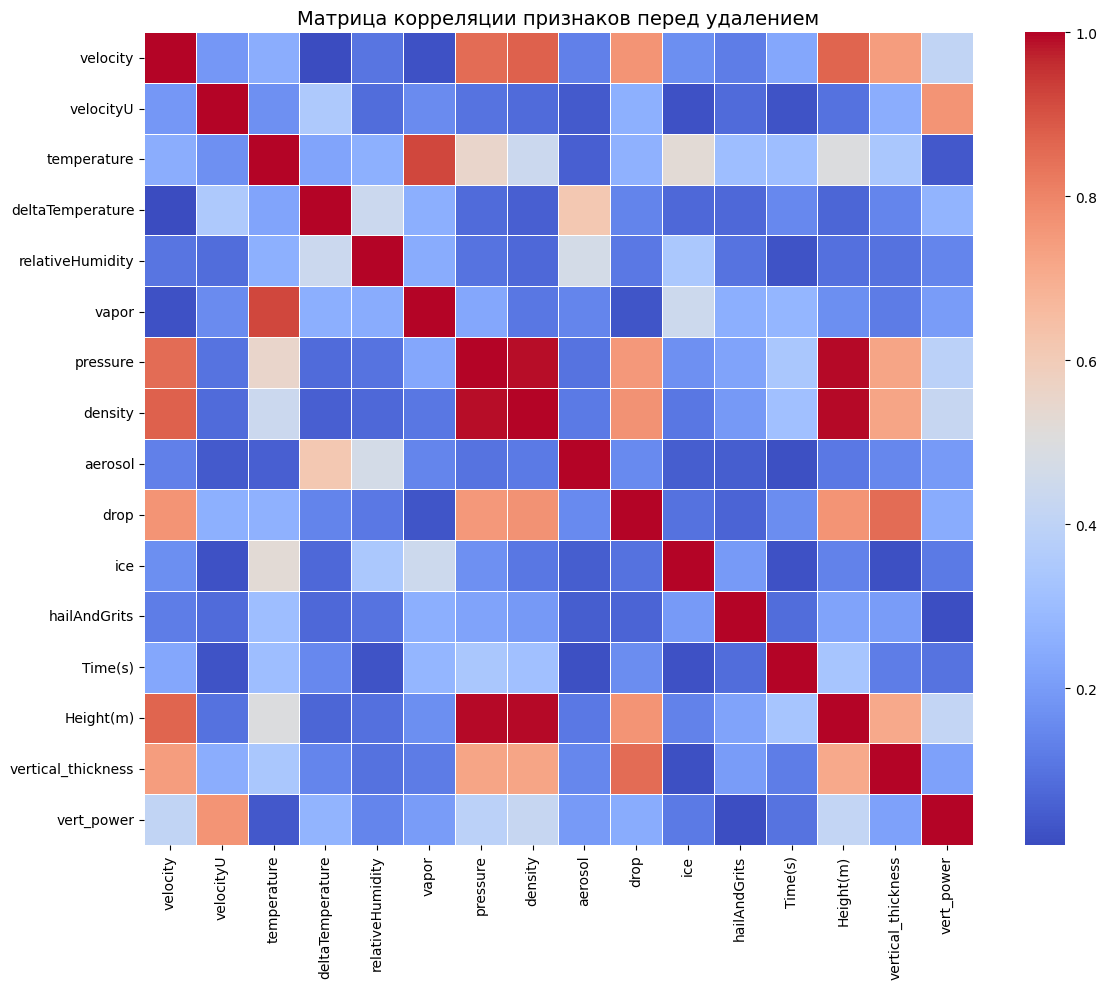

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Результаты моделей:

              Model  Accuracy  Precision   Recall  F1-Score  CV Accuracy  AUC ROC
      Random Forest  0.873874   0.874739 0.862121  0.867134     0.810244 0.940236
            XGBoost  0.846847   0.844203 0.835859  0.839336     0.796700 0.904714
  Gradient Boosting  0.837838   0.839744 0.821212  0.827640     0.817108 0.904377
                KNN  0.747748   0.738384 0.738384  0.738384     0.650012 0.792088
           AdaBoost  0.720721   0.710142 0.708586  0.709301     0.738111 0.769697
      Decision Tree  0.711712   0.705392 0.711616  0.706349     0.708755 0.818350
Logistic Regression  0.648649   0.631939 0.623232  0.624772     0.708770 0.700673
                SVM  0.648649   0.631939 0.623232  0.624772     0.695226 0.676768
   Ridge Classifier  0.639640   0.623345 0.619192  0.620383     0.699715 0.675758

 Сильно коррелированные признаки (удалены):
['density', 'Height(m)']

 Важность признаков:

Модель: Random Forest
pressure: 0.1049
temperature: 0.1039
veloci

<ipython-input-26-2f29ff06c970>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y='Model', data=results_df, palette='viridis')
<ipython-input-26-2f29ff06c970>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y='Model', data=results_df, palette='viridis')
<ipython-input-26-2f29ff06c970>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y='Model', data=results_df, palette='viridis')


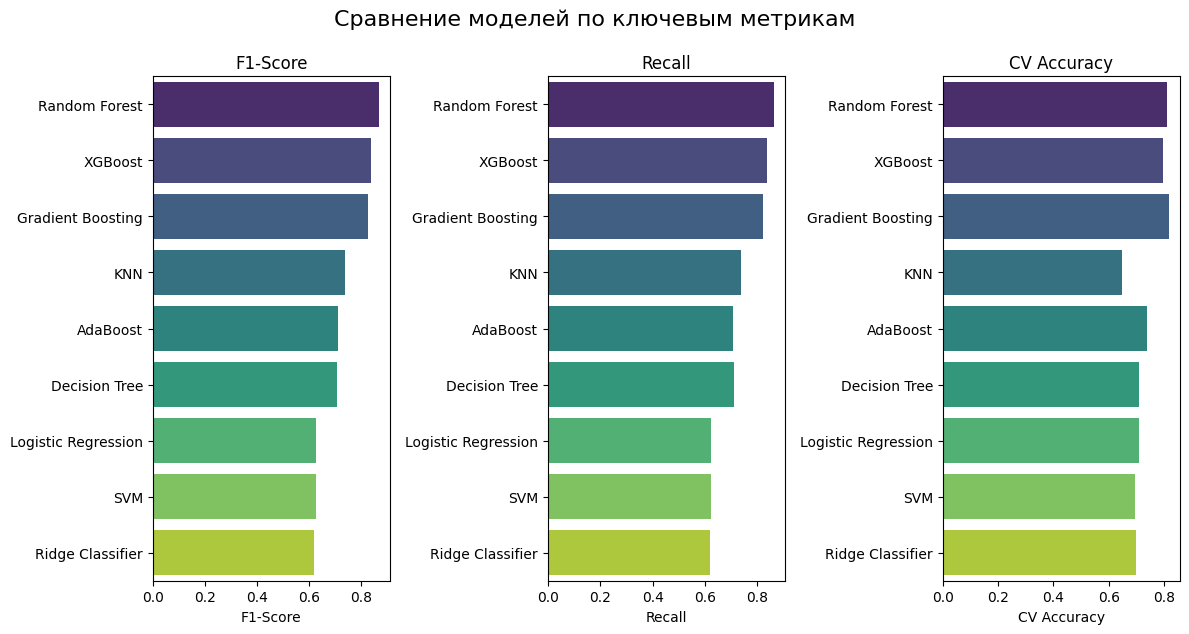

<ipython-input-26-2f29ff06c970>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=features, ax=axes[idx], palette='viridis')
<ipython-input-26-2f29ff06c970>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=features, ax=axes[idx], palette='viridis')
<ipython-input-26-2f29ff06c970>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=features, ax=axes[idx], palette='viridis')
<ipython-input-26-2f29ff06c970>:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in 

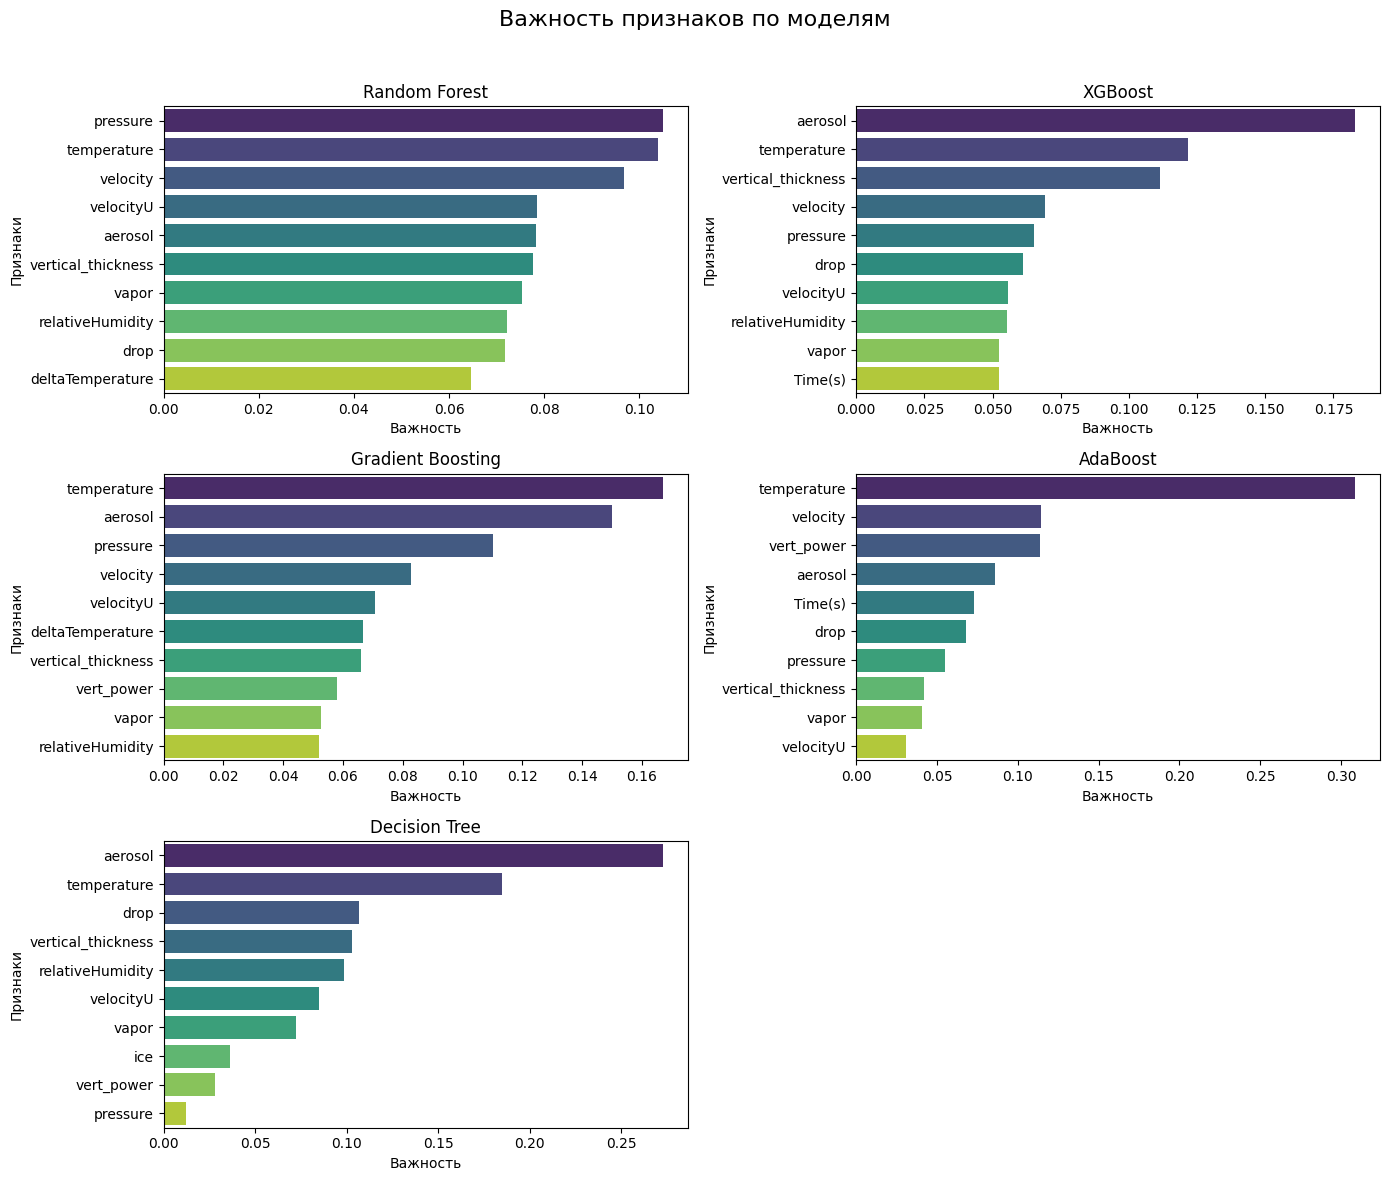

In [ ]:
df_balanced = balanced_df(df)
df = df_balanced.copy().dropna()

X = df.drop(columns=['target', 'term'])
y = df['target']


# удаление сильно коррел признаков
corr_matrix = pd.DataFrame(X).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=to_drop)

# корреляционная матрица
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции признаков перед удалением', fontsize=14)
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(C=1.0, kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Ridge Classifier": RidgeClassifier()
}

results = []
feature_importance_before = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        y_prob = None

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=3).mean()

    auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'CV Accuracy': cv_accuracy,
        'AUC ROC': auc_roc
    })


    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance_before[name] = dict(zip(X.columns, importance))

results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("\nРезультаты моделей:\n")
print(results_df.to_string(index=False))

print("\n Сильно коррелированные признаки (удалены):")
print(to_drop)

print("\n Важность признаков:")

for model_name, importances in feature_importance_before.items():
    sorted_features = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nМодель: {model_name}")
    for feature, score in sorted_features:
        print(f"{feature}: {score:.4f}")



import matplotlib.pyplot as plt
import seaborn as sns

# график сравнения моделей по F1-score, Recall и CV Accuracy
plt.figure(figsize=(12, 6))
metrics = ['F1-Score', 'Recall', 'CV Accuracy']

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x=metric, y='Model', data=results_df, palette='viridis')
    plt.title(metric)
    plt.xlabel(metric)
    plt.ylabel('')

plt.tight_layout()
plt.suptitle('Сравнение моделей по ключевым метрикам', fontsize=16, y=1.05)
plt.show()

#

models_with_importance = list(feature_importance_before.keys())
n_models = len(models_with_importance)

# сетка для отображения в одной картинке
n_rows = (n_models + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for idx, (model_name, importances) in enumerate(feature_importance_before.items()):
    sorted_items = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]
    features, scores = zip(*sorted_items)

    sns.barplot(x=scores, y=features, ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'{model_name}', fontsize=12)
    axes[idx].set_xlabel('Важность')
    axes[idx].set_ylabel('Признаки')

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Важность признаков по моделям', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
scorer = make_scorer(recall_score)

# кол-во фолдов и итераций
cv_folds = 5  # 3
n_iter_search = 50  # 20

# 1 Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=n_iter_search, scoring=scorer, cv=cv_folds, n_jobs=-1, random_state=42)
rf_search.fit(X_train, y_train)

# 2 XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=n_iter_search, scoring=scorer, cv=cv_folds, n_jobs=-1, random_state=42)
xgb_search.fit(X_train, y_train)

# 3 Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0]
}
gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(gb, gb_param_grid, n_iter=n_iter_search, scoring=scorer, cv=cv_folds, n_jobs=-1, random_state=42)
gb_search.fit(X_train, y_train)

model_results = [
    {
        'Model': 'Random Forest',
        'Best Recall (CV)': rf_search.best_score_,
        'Best Params': rf_search.best_params_
    },
    {
        'Model': 'XGBoost',
        'Best Recall (CV)': xgb_search.best_score_,
        'Best Params': xgb_search.best_params_
    },
    {
        'Model': 'Gradient Boosting',
        'Best Recall (CV)': gb_search.best_score_,
        'Best Params': gb_search.best_params_
    }
]

# формируем датафрейм и сортируем по убыванию recall
df_results = pd.DataFrame(model_results)
df_results.sort_values(by='Best Recall (CV)', ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)

print("\nРейтинг моделей по Recall (CV):\n")
for idx, row in df_results.iterrows():
    print(f"Место {idx + 1}: {row['Model']}")
    print(f"Recall (CV): {row['Best Recall (CV)']:.4f}")
    print(f"Лучшие гиперпараметры: {row['Best Params']}\n")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Рейтинг моделей по Recall (CV):

Место 1: XGBoost
Recall (CV): 0.9125
Лучшие гиперпараметры: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}

Место 2: Random Forest
Recall (CV): 0.9009
Лучшие гиперпараметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}

Место 3: Gradient Boosting
Recall (CV): 0.8971
Лучшие гиперпараметры: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01}



In [ ]:
# предсказания на тестовой выборке
rf_pred = rf_search.best_estimator_.predict(X_test)
xgb_pred = xgb_search.best_estimator_.predict(X_test)
gb_pred = gb_search.best_estimator_.predict(X_test)

# расчет Recall
rf_recall = recall_score(y_test, rf_pred)
xgb_recall = recall_score(y_test, xgb_pred)
gb_recall = recall_score(y_test, gb_pred)

print(f"Random Forest Recall (Test): {rf_recall:.4f}")
print(f"XGBoost Recall (Test): {xgb_recall:.4f}")
print(f"Gradient Boosting Recall (Test): {gb_recall:.4f}")


Random Forest Recall (Test): 0.9394
XGBoost Recall (Test): 0.9545
Gradient Boosting Recall (Test): 0.9394



Топ-10 признаков по важности для Random Forest:
temperature           0.116640
pressure              0.105940
aerosol               0.097163
velocity              0.091020
vertical_thickness    0.083363
vapor                 0.075306
velocityU             0.074162
relativeHumidity      0.070382
drop                  0.068397
vert_power            0.057847
dtype: float64

Топ-10 признаков по важности для Gradient Boosting:
temperature           0.131040
pressure              0.119115
velocity              0.099231
aerosol               0.092394
relativeHumidity      0.088174
vertical_thickness    0.071616
velocityU             0.071348
vapor                 0.063116
deltaTemperature      0.061170
drop                  0.059808
dtype: float64

Топ-10 признаков по важности для XGBoost:
aerosol               0.194379
vertical_thickness    0.106981
temperature           0.098710
pressure              0.069861
velocity              0.062121
vapor                 0.060625
drop               

<ipython-input-16-940bb1010781>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette='viridis')
<ipython-input-16-940bb1010781>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette='viridis')
<ipython-input-16-940bb1010781>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette='viridis')


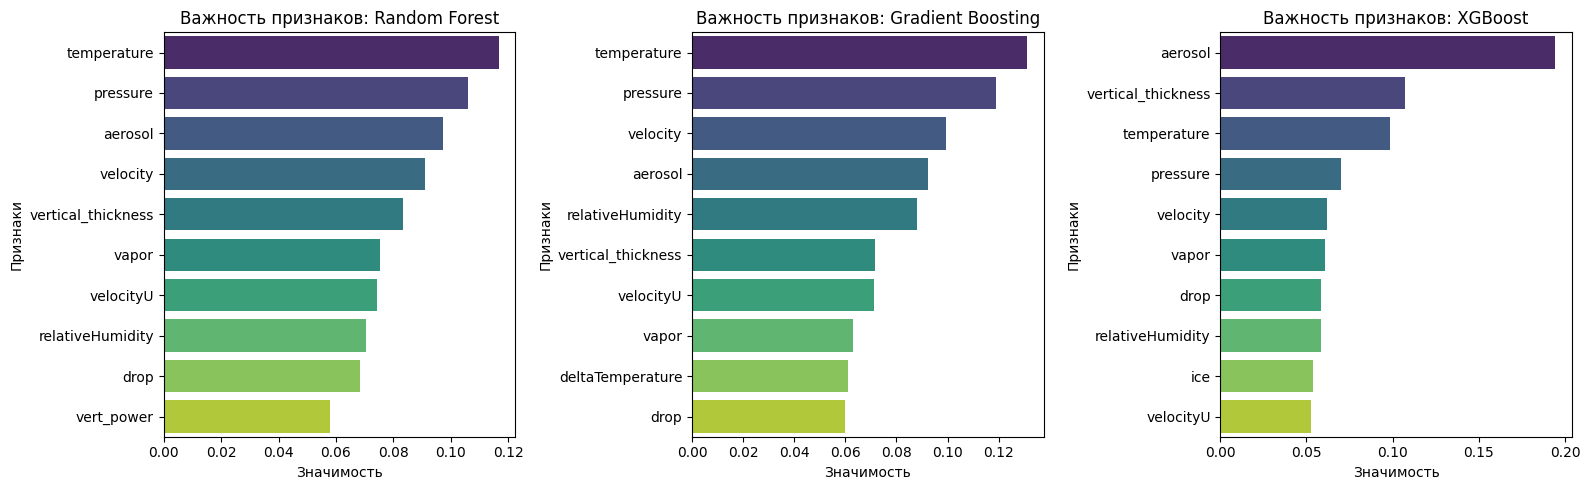

In [ ]:
models = {
    "Random Forest": rf_search.best_estimator_,
    "Gradient Boosting": gb_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
}

feature_importance_after  = {}

for name, model in models.items():

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_after[name] = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    else:
        print(f"Модель {name} не поддерживает feature_importances_")

# топ-10 важных признаков для каждой модели
for name, importances in feature_importance_after.items():
    print(f"\nТоп-10 признаков по важности для {name}:")
    print(importances.head(10))

# график
plt.figure(figsize=(16, 5))
for i, (name, importances) in enumerate(feature_importance_after.items(), 1):
    plt.subplot(1, 3, i)
    sns.barplot(x=importances.head(10).values, y=importances.head(10).index, palette='viridis')
    plt.title(f'Важность признаков: {name}')
    plt.xlabel('Значимость')
    plt.ylabel('Признаки')
plt.tight_layout()
plt.show()



=== Модель: Random Forest ===
           Feature  Before  After
       temperature  0.1039 0.1166
          pressure  0.1049 0.1059
           aerosol  0.0783 0.0972
          velocity  0.0967 0.0910
vertical_thickness  0.0776 0.0834
             vapor  0.0754 0.0753
         velocityU  0.0785 0.0742
  relativeHumidity  0.0721 0.0704
              drop  0.0717 0.0684
        vert_power  0.0610 0.0578
  deltaTemperature  0.0646 0.0539


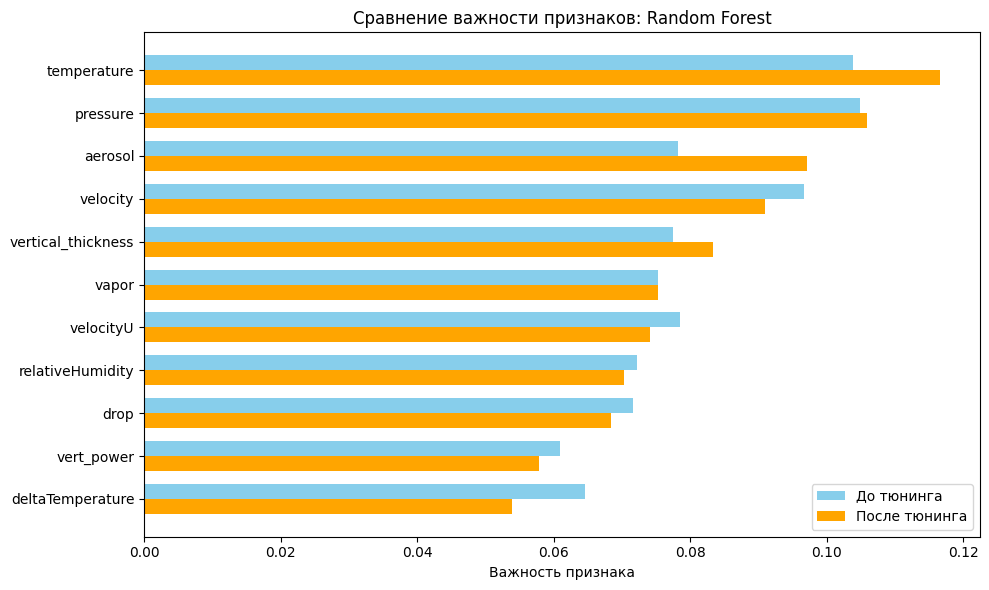

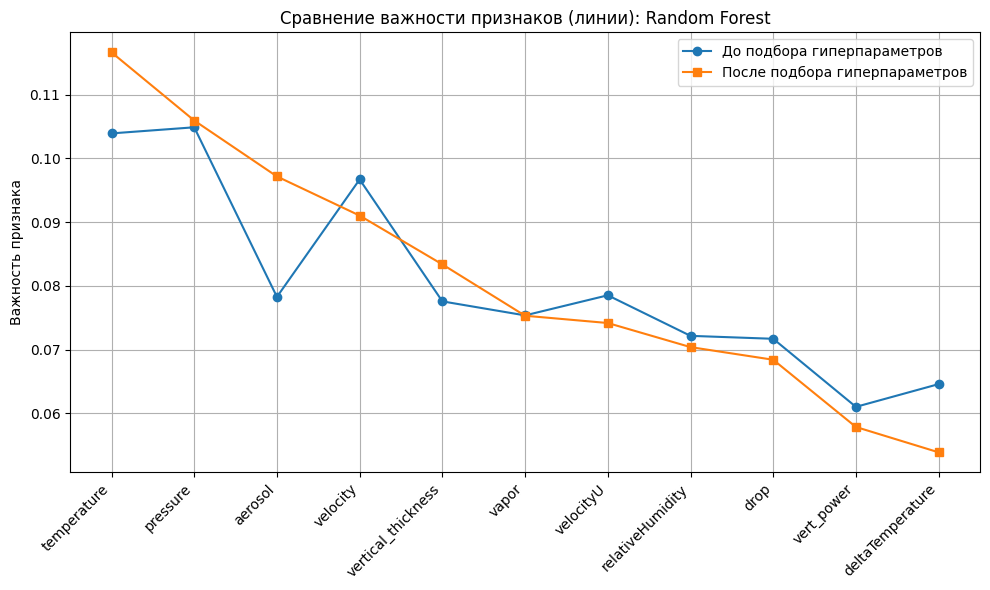


=== Модель: XGBoost ===
           Feature  Before  After
           aerosol  0.1829 0.1944
vertical_thickness  0.1113 0.1070
       temperature  0.1216 0.0987
          pressure  0.0651 0.0699
          velocity  0.0692 0.0621
             vapor  0.0523 0.0606
              drop  0.0613 0.0586
  relativeHumidity  0.0555 0.0585
               ice  0.0489 0.0537
         velocityU  0.0557 0.0528
           Time(s)  0.0523 0.0468


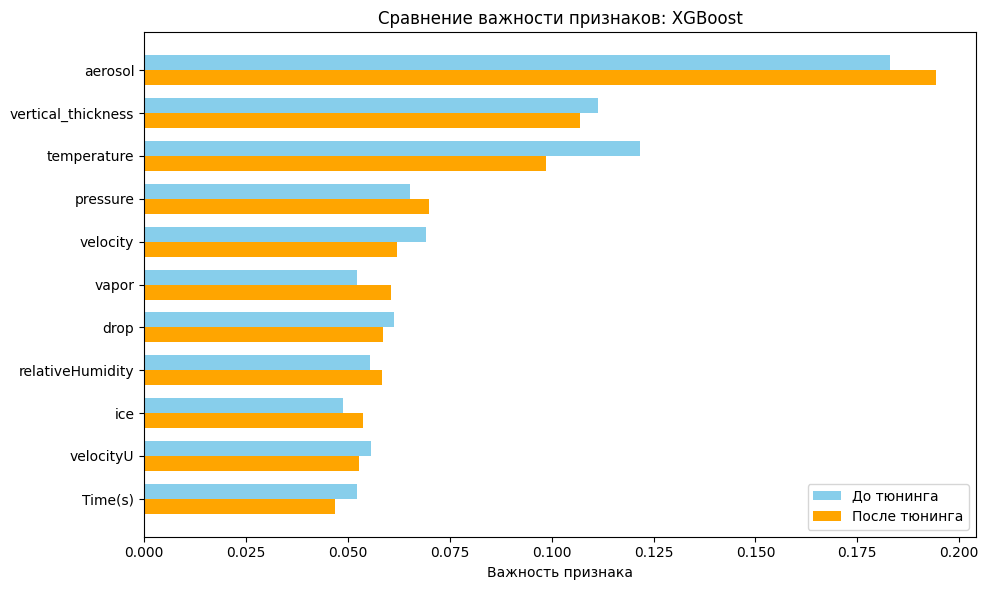

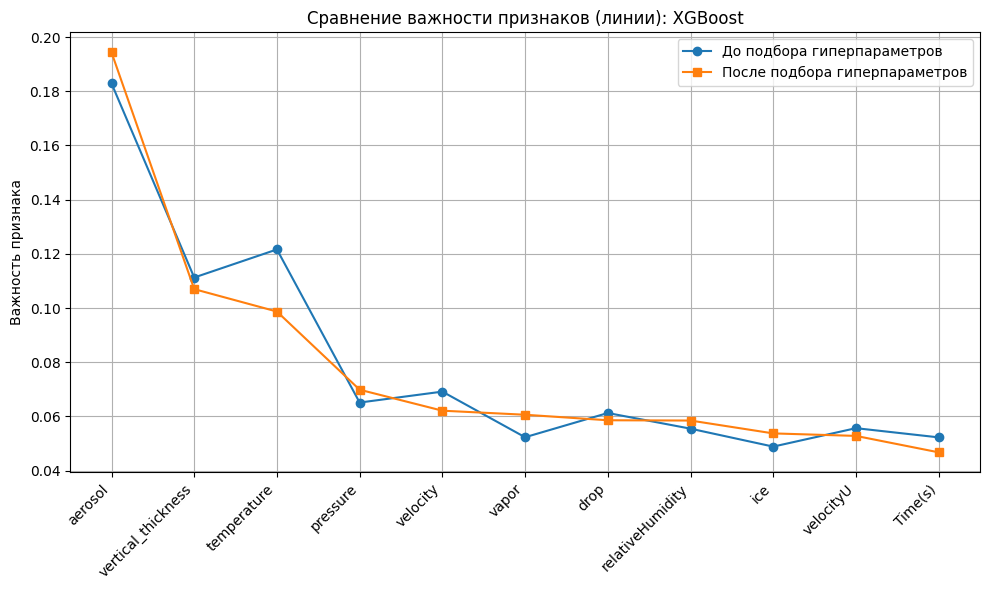


=== Модель: Gradient Boosting ===
           Feature  Before  After
       temperature  0.1669 0.1310
          pressure  0.1102 0.1191
          velocity  0.0828 0.0992
           aerosol  0.1499 0.0924
  relativeHumidity  0.0518 0.0882
vertical_thickness  0.0660 0.0716
         velocityU  0.0707 0.0713
             vapor  0.0526 0.0631
  deltaTemperature  0.0668 0.0612
              drop  0.0504 0.0598
        vert_power  0.0580 0.0523


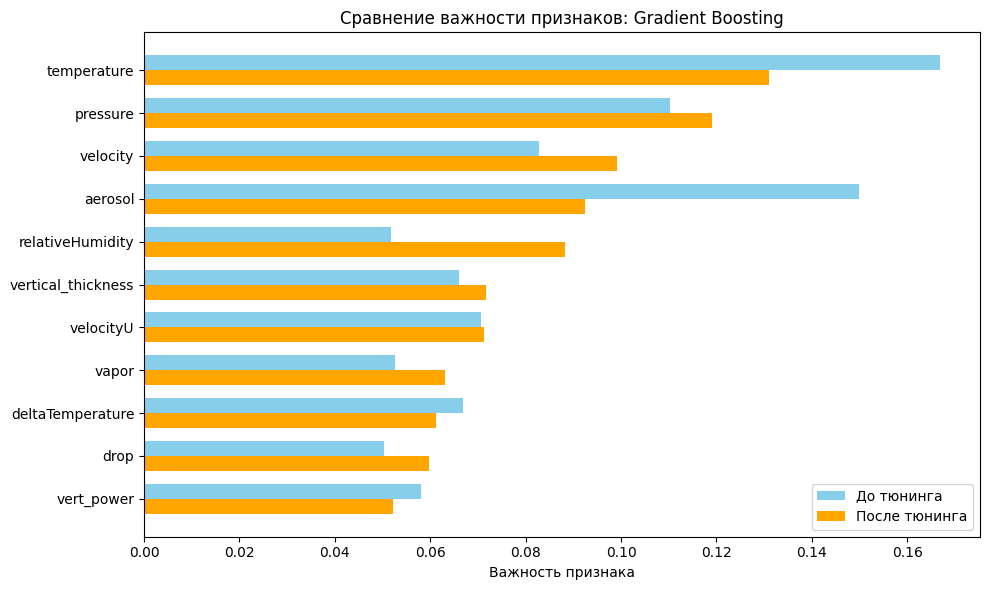

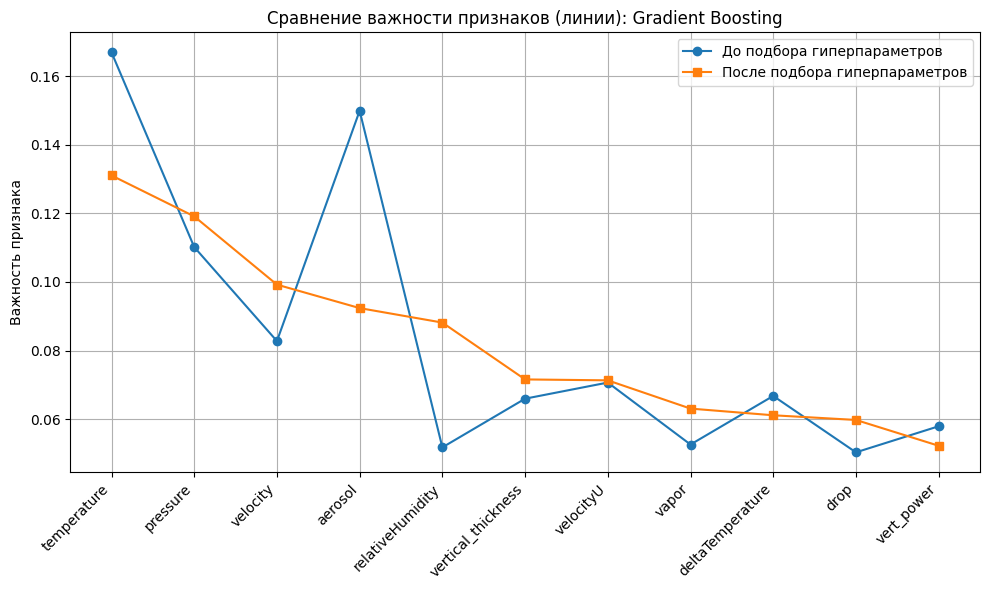

In [ ]:
def compare_feature_importances(feature_importance_before, feature_importance_after, top_n=10):
    dfs = {}

    # берём только модели, которые есть в обоих случаях
    common_models = set(feature_importance_before.keys()) & set(feature_importance_after.keys())

    for model in common_models:
        before_series = pd.Series(feature_importance_before[model])
        after_series = pd.Series(feature_importance_after[model])

        top_features_before = before_series.sort_values(ascending=False).head(top_n).index
        top_features_after = after_series.sort_values(ascending=False).head(top_n).index
        combined_features = list(set(top_features_before).union(set(top_features_after)))

        df_compare = pd.DataFrame({
            'Feature': combined_features,
            'Before': before_series.reindex(combined_features).fillna(0),
            'After': after_series.reindex(combined_features).fillna(0)
        }).sort_values(by='After', ascending=False).reset_index(drop=True)

        dfs[model] = df_compare

        # текстовый вывод
        print(f"\n=== Модель: {model} ===")
        print(df_compare.to_string(index=False, float_format='{:.4f}'.format))

        # график
        ind = np.arange(len(df_compare))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.barh(ind - width/2, df_compare['Before'], width, label='До тюнинга', color='skyblue')
        plt.barh(ind + width/2, df_compare['After'], width, label='После тюнинга', color='orange')

        plt.yticks(ind, df_compare['Feature'])
        plt.xlabel('Важность признака')
        plt.title(f'Сравнение важности признаков: {model}')
        plt.legend()
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        plot_feature_importances_lines(df_compare, model)

    if not common_models:
        print("Нет общих моделей для сравнения.")

    return dfs

import matplotlib.pyplot as plt

def plot_feature_importances_lines(df_compare, model_name):
    plt.figure(figsize=(10, 6))

    # индексы по признакам для оси х
    x = range(len(df_compare))
    features = df_compare['Feature']

    plt.plot(x, df_compare['Before'], marker='o', label='До подбора гиперпараметров')
    plt.plot(x, df_compare['After'], marker='s', label='После подбора гиперпараметров')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Важность признака')
    plt.title(f'Сравнение важности признаков (линии): {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


dfs_comparison = compare_feature_importances(feature_importance_before, feature_importance_after)


In [ ]:
# статистические тесты
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# модели с лучшими параметрами
rf_best = RandomForestClassifier(**rf_search.best_params_, random_state=42)
gb_best = GradientBoostingClassifier(**gb_search.best_params_, random_state=42)
xgb_best = XGBClassifier(**xgb_search.best_params_, random_state=42, use_label_encoder=False, eval_metric='logloss')

rf_cv_scores = cross_val_score(rf_best, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
gb_cv_scores = cross_val_score(gb_best, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb_best, X_train, y_train, cv=cv, scoring='recall', n_jobs=-1)

print("Recall CV по фолдам:")
print(f"Random Forest: {rf_cv_scores} Среднее: {rf_cv_scores.mean():.4f}")
print(f"Gradient Boosting: {gb_cv_scores} Среднее: {gb_cv_scores.mean():.4f}")
print(f"XGBoost: {xgb_cv_scores} Среднее: {xgb_cv_scores.mean():.4f}")

# Т-критерий Стьюдента
print("\nТ-критерий Стьюдента по recall на CV:")
t_stat_rf_gb, p_val_rf_gb = ttest_rel(rf_cv_scores, gb_cv_scores)
t_stat_rf_xgb, p_val_rf_xgb = ttest_rel(rf_cv_scores, xgb_cv_scores)
t_stat_gb_xgb, p_val_gb_xgb = ttest_rel(gb_cv_scores, xgb_cv_scores)

print(f"RF vs GB: t={t_stat_rf_gb:.4f}, p={p_val_rf_gb:.4f}")
print(f"RF vs XGB: t={t_stat_rf_xgb:.4f}, p={p_val_rf_xgb:.4f}")
print(f"GB vs XGB: t={t_stat_gb_xgb:.4f}, p={p_val_gb_xgb:.4f}")

# критерий Уилкоксона
print("\nКритерий Уилкоксона по recall на CV:")
w_stat_rf_gb, w_p_val_rf_gb = wilcoxon(rf_cv_scores, gb_cv_scores)
w_stat_rf_xgb, w_p_val_rf_xgb = wilcoxon(rf_cv_scores, xgb_cv_scores)
w_stat_gb_xgb, w_p_val_gb_xgb = wilcoxon(gb_cv_scores, xgb_cv_scores)

print(f"RF vs GB: stat={w_stat_rf_gb}, p={w_p_val_rf_gb:.4f}")
print(f"RF vs XGB: stat={w_stat_rf_xgb}, p={w_p_val_rf_xgb:.4f}")
print(f"GB vs XGB: stat={w_stat_gb_xgb}, p={w_p_val_gb_xgb:.4f}")

# дисперсионный анализ
print("\nДисперсионный анализ по recall на CV:")
f_stat, p_val_anova = f_oneway(rf_cv_scores, gb_cv_scores, xgb_cv_scores)
print(f"ANOVA F-statistic={f_stat:.4f}, p-value={p_val_anova:.4f}")

# # обучение на всем train и проверка на test
# rf_best.fit(X_train, y_train)
# gb_best.fit(X_train, y_train)
# xgb_best.fit(X_train, y_train)

# rf_test_pred = rf_best.predict(X_test)
# gb_test_pred = gb_best.predict(X_test)
# xgb_test_pred = xgb_best.predict(X_test)

# print("\nRecall на тестовой выборке:")
# print(f"Random Forest: {recall_score(y_test, rf_test_pred):.4f}")
# print(f"Gradient Boosting: {recall_score(y_test, gb_test_pred):.4f}")
# print(f"XGBoost: {recall_score(y_test, xgb_test_pred):.4f}")


Recall CV по фолдам:
Random Forest: [0.98113208 0.8490566  0.8490566  0.82692308 0.86538462] Среднее: 0.8743
Gradient Boosting: [0.96226415 0.81132075 0.90566038 0.86538462 0.86538462] Среднее: 0.8820
XGBoost: [0.98113208 0.86792453 0.86792453 0.86538462 0.88461538] Среднее: 0.8934

Т-критерий Стьюдента по recall на CV:
RF vs GB: t=-0.4380, p=0.6840
RF vs XGB: t=-3.1381, p=0.0349
GB vs XGB: t=-0.7428, p=0.4988

Критерий Уилкоксона по recall на CV:
RF vs GB: stat=3.0, p=0.6250
RF vs XGB: stat=0.0, p=0.1250
GB vs XGB: stat=3.0, p=0.6250

Дисперсионный анализ по recall на CV:
ANOVA F-statistic=0.1479, p-value=0.8641
